<a href="https://colab.research.google.com/github/claytonmclamb/MinorityOS/blob/main/DAE_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attempting a Denoising AE

## Loading Packages

In [298]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import torch
import numpy as np
from datetime import datetime
from torch.utils.data import DataLoader
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import pandas as pd
import gc
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset

from sklearn import datasets

## Loading & Preparing Data (Iris)

In [330]:
data = datasets.load_iris()
X = data['data']
y = data['target']

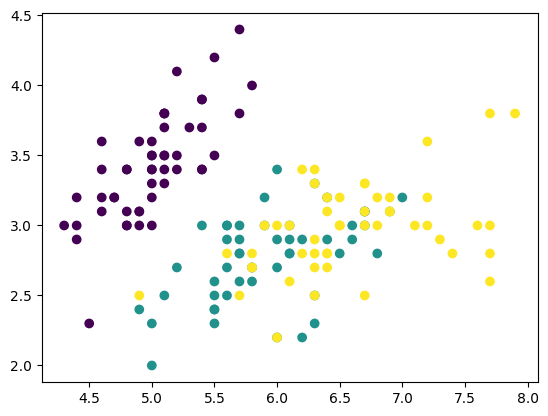

In [331]:
#map = {0:"red", 1}
plt.scatter(X[:,0], X[:,1], c = y)

In [332]:
mask = y != 2
X = X[mask]
y = y[mask]

In [333]:
X = (X- X.min()) / (X.max() - X.min())

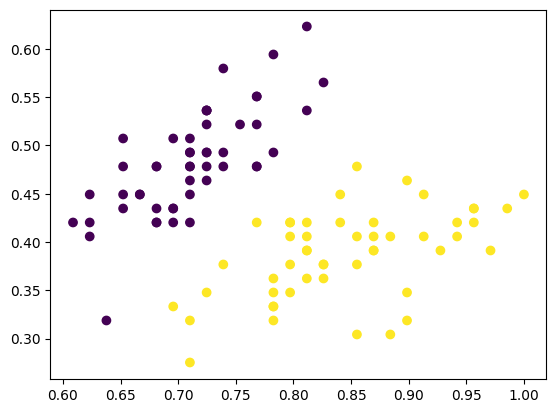

In [334]:
plt.scatter(X[:,0], X[:,1], c = y)

In [344]:
mask = y == 1
X0 = X[mask]
y0 = y[mask]
X2 = X[~mask]
y2 = y[~mask]

## Preparing the Model

### Loss Functions

In [537]:
def loss_function(recon_x, x, mu, logvar):
    # Compute Mean Squared Error (MSE) loss
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')

    # Compute Kullback-Leibler (KL) Divergence
    #kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = torch.mean(torch.sum(kl_loss))
    #tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))


    # Total loss is a combination of MSE loss and KL Divergence
    # You can adjust the weight of each term based on your preference
    # Here, we're weighting them equally
    total_loss = mse_loss #+ kl_loss

    return total_loss

### Model Architecture

In [538]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
      # if not self.training:
      #    return mu
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define your dataset and dataloader, then train the VAE model.
# Ensure the input_dim, hidden_dim, and latent_dim are appropriately set.

# DataSet and DataLoader

In [539]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        # Assuming each sample is a tuple of features and labels
        features, labels = sample[0], sample[1]
        return torch.tensor(features, dtype=torch.float), torch.tensor(labels, dtype=torch.float)

# Example data
data0 = [(feature_vector, label) for feature_vector, label in zip(X0, y0)]
data2 = [(feature_vector, label) for feature_vector, label in zip(X2, y2)]


# Create an instance of the custom dataset
custom_dataset0 = CustomDataset(data0)
custom_dataset2 = CustomDataset(data2)

# Define parameters for DataLoader
batch_size = 25
shuffle = False

# Create a DataLoader
data_loader0 = DataLoader(dataset=custom_dataset0, batch_size=batch_size, shuffle=shuffle)
data_loader1 = DataLoader(dataset=custom_dataset2, batch_size=batch_size, shuffle=shuffle)


In [540]:
def train(model, dataloader0, dataloader2, optimizer, criterion, num_epochs):
    # Set the model to training mode
    model.train()
    losses = []
    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        i = 0
        for data0, data2 in zip(dataloader0, dataloader2):
        #for i, (inputs, labels) in enumerate(dataloader):
            inputs0, labels0 = data0[0], data0[1]
            inputs2, labels2 = data2[0], data2[1]
            #print(inputs0, inputs2, labels0, labels2, sep = "\n")
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs0)
            recon, mu, logvar = outputs
            # Compute the loss
            loss0 = criterion(recon, inputs0, mu, logvar)


            # Forward pass
            outputs = model(inputs2)
            recon, mu, logvar = outputs
            # Compute the loss
            loss2 = criterion(recon, inputs2, mu, logvar)

            loss = loss0 + loss2
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if epoch % 1 == 0:    # Print every 100 mini-batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{(len(dataloader0) + len(dataloader2))}], Loss: {running_loss/100:.4f}')
                #running_loss = 0.0
            i += 1
        losses.append(running_loss)
        running_loss

    print('Finished Training')
    return losses

In [541]:
import torch.optim as optim

In [552]:
model = VAE(4, 512, 3)
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = loss_function

In [553]:
epochs = 500
losses = train(model, data_loader0, data_loader1, optimizer, criterion, epochs)

Epoch [1/500], Step [1/4], Loss: 0.2000
Epoch [1/500], Step [2/4], Loss: 0.3774
Epoch [2/500], Step [1/4], Loss: 0.1605
Epoch [2/500], Step [2/4], Loss: 0.3065
Epoch [3/500], Step [1/4], Loss: 0.1273
Epoch [3/500], Step [2/4], Loss: 0.2458
Epoch [4/500], Step [1/4], Loss: 0.1119
Epoch [4/500], Step [2/4], Loss: 0.2166
Epoch [5/500], Step [1/4], Loss: 0.0912
Epoch [5/500], Step [2/4], Loss: 0.1714
Epoch [6/500], Step [1/4], Loss: 0.0776
Epoch [6/500], Step [2/4], Loss: 0.1509
Epoch [7/500], Step [1/4], Loss: 0.0624
Epoch [7/500], Step [2/4], Loss: 0.1190
Epoch [8/500], Step [1/4], Loss: 0.0593
Epoch [8/500], Step [2/4], Loss: 0.1165
Epoch [9/500], Step [1/4], Loss: 0.0542
Epoch [9/500], Step [2/4], Loss: 0.1021
Epoch [10/500], Step [1/4], Loss: 0.0456
Epoch [10/500], Step [2/4], Loss: 0.0887
Epoch [11/500], Step [1/4], Loss: 0.0406
Epoch [11/500], Step [2/4], Loss: 0.0801
Epoch [12/500], Step [1/4], Loss: 0.0406
Epoch [12/500], Step [2/4], Loss: 0.0804
Epoch [13/500], Step [1/4], Loss: 

In [554]:
import matplotlib.pyplot as plt

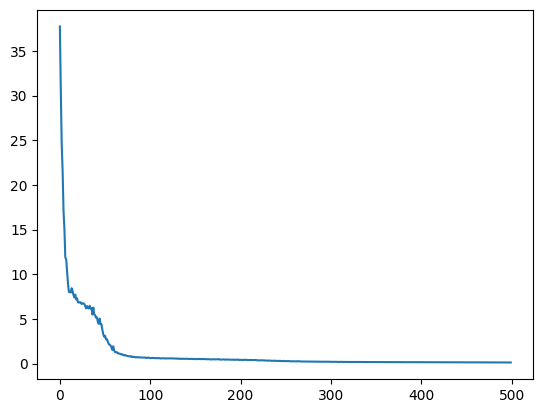

In [555]:
plt.plot(np.arange(epochs), losses)

In [556]:
len(losses)

500

In [557]:
model.eval()

VAE(
  (fc1): Linear(in_features=4, out_features=512, bias=True)
  (fc21): Linear(in_features=512, out_features=3, bias=True)
  (fc22): Linear(in_features=512, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4, bias=True)
)

In [558]:
for i, (inputs0, labels) in enumerate(data_loader0):
  #print(inputs, labels)
  recon0, mu0, logvar0 = model(inputs0)

In [559]:
for i, (inputs1, labels) in enumerate(data_loader1):
  #print(inputs, labels)
  recon1, mu1, logvar1 = model(inputs1)

In [560]:
logvar0

tensor([[-8.3305, -9.4771, -8.2686],
        [-8.5571, -9.6783, -8.5223],
        [-8.6573, -9.7202, -8.6138],
        [-8.1114, -9.1842, -8.0455],
        [-7.4697, -8.6644, -7.3779],
        [-7.4916, -8.6252, -7.4151],
        [-7.4394, -8.5947, -7.3613],
        [-7.7142, -8.8584, -7.6342],
        [-8.3472, -9.3483, -8.3105],
        [-7.8679, -8.8944, -7.7900],
        [-8.1913, -9.2650, -8.1062],
        [-8.5240, -9.6412, -8.4707],
        [-8.0958, -9.2118, -8.0526],
        [-7.7644, -8.8681, -7.6783],
        [-7.6100, -8.7026, -7.5334],
        [-7.7821, -8.8524, -7.7236],
        [-8.2001, -9.2871, -8.1401],
        [-7.7424, -8.8749, -7.6701],
        [-7.0443, -8.1933, -6.9426],
        [-7.7649, -8.8520, -7.6926],
        [-7.8392, -8.9544, -7.7621],
        [-7.8356, -8.9359, -7.7585],
        [-8.0924, -9.2251, -8.0268],
        [-7.0004, -8.1766, -6.8757],
        [-7.7796, -8.8868, -7.7011]], grad_fn=<AddmmBackward0>)

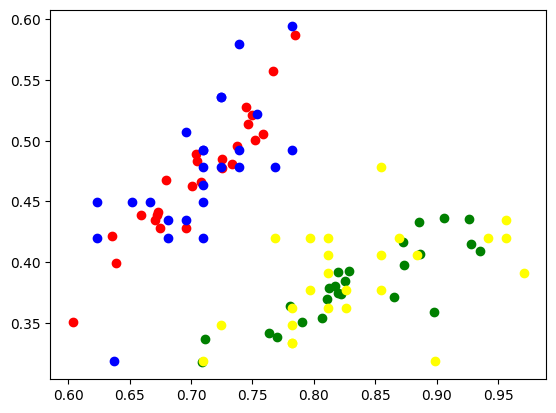

In [561]:
plt.scatter(recon0.detach().numpy()[:,0], recon0.detach().numpy()[:,1], c = "green")
plt.scatter(inputs0.detach().numpy()[:,0], inputs0.detach().numpy()[:,1], c = "yellow")

plt.scatter(recon1.detach().numpy()[:,0], recon1.detach().numpy()[:,1], c = "red")
plt.scatter(inputs1.detach().numpy()[:,0], inputs1.detach().numpy()[:,1], c = "blue")

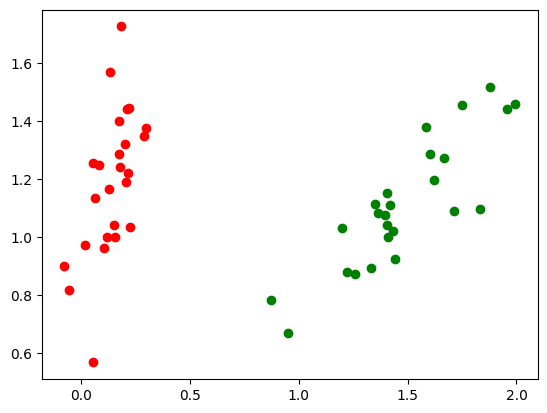

In [562]:
plt.scatter(mu0.detach().numpy()[:,0], mu0.detach().numpy()[:,1], c = "green")
plt.scatter(mu1.detach().numpy()[:,0], mu1.detach().numpy()[:,1], c = "red")